In [1]:
import os
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from PIL import Image        
from skimage.io import imread
from skimage.transform import resize

In [2]:
import Augmentor
Augmentor.__version__

'0.2.0-fix'

In [3]:
from keras.models import load_model
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

c:\p3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load and resize the images

In [4]:
IMG_HEIGHT, IMG_WIDTH = 128, 256
SEED=42

IMAGE_LIB = 'C:\\Users\\kovsa\\input\\images\\'
MASK_LIB = 'C:\\Users\\kovsa\\input\\masks\\'

In [5]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.bmp']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(os.path.join(IMAGE_LIB, name), cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(os.path.join(MASK_LIB, name), cv2.IMREAD_GRAYSCALE).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im


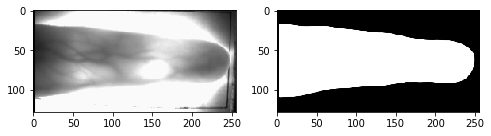

In [6]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [7]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

## Define and train model

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [9]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 128, 8)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 128, 16)  1168        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

# Use Augmentor 

In [11]:
# p = Augmentor.Pipeline("C://Users/kovsa/input/images")
# p.ground_truth("C://Users/kovsa/input/masks")

# p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
# p.flip_left_right(probability=0.5)
# p.zoom_random(probability=0.5, percentage_area=0.8)
# p.flip_top_bottom(probability=0.5)

# p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
# p.flip_left_right(probability=0.5)
# p.zoom_random(probability=0.5, percentage_area=0.8)
# p.flip_top_bottom(probability=0.5)
# #p.random_erasing(0.4,0.4)
# # p.add_operation(RandomErasing(0.4,0.4))

# p.sample(10000)

# Train model

In [12]:
def my_generator(x_train, y_train, batch_size):    
    data_generator = ImageDataGenerator()
    data_generator.fit(x_train, batch_size, seed=SEED)
    data_generator = data_generator.flow(x_train, batch_size=batch_size, seed=SEED)
    
    mask_generator = ImageDataGenerator()
    mask_generator.fit(y_train, batch_size, seed=SEED)
    mask_generator = mask_generator.flow(y_train, batch_size=batch_size, seed=SEED)

    return zip(data_generator, mask_generator)

Check this, to be safe.

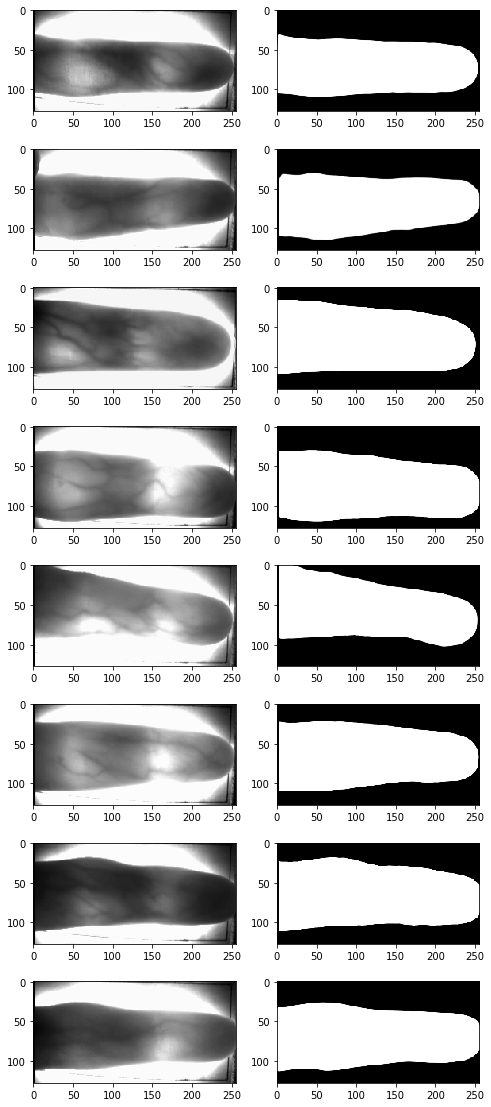

In [13]:
gen = my_generator(x_train, y_train, 8)
image_batch, mask_batch = next(gen)
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [14]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [15]:
from keras.callbacks import TensorBoard

weight_saver = ModelCheckpoint('checkpoints/lung_{epoch:02d}-{val_dice_coef:.2f}.h5', monitor='val_dice_coef', 
                                              save_best_only=False, verbose=1)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
name='example'
tensor_board = TensorBoard(log_dir=os.path.join('output', name))

In [18]:
EPOCHES = 5 #50

hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 2, #200
                           validation_data = (x_val, y_val),
                           epochs=EPOCHES,
                           callbacks = [weight_saver, annealer, tensor_board])

Epoch 1/5
2/2 [==============================] - ETA: 1s - loss: 0.6654 - dice_coef: 0.537 - 6s 3s/step - loss: 0.6624 - dice_coef: 0.5343 - val_loss: 0.6582 - val_dice_coef: 0.5208

Epoch 00001: saving model to checkpoints/lung_01-0.52.h5
Epoch 2/5
2/2 [==============================] - ETA: 2s - loss: 0.6663 - dice_coef: 0.497 - 4s 2s/step - loss: 0.6568 - dice_coef: 0.5151 - val_loss: 0.6489 - val_dice_coef: 0.5236

Epoch 00002: saving model to checkpoints/lung_02-0.52.h5
Epoch 3/5
2/2 [==============================] - ETA: 2s - loss: 0.6475 - dice_coef: 0.541 - 5s 3s/step - loss: 0.6464 - dice_coef: 0.5338 - val_loss: 0.6407 - val_dice_coef: 0.5267

Epoch 00003: saving model to checkpoints/lung_03-0.53.h5
Epoch 4/5
2/2 [==============================] - ETA: 2s - loss: 0.6481 - dice_coef: 0.510 - 4s 2s/step - loss: 0.6373 - dice_coef: 0.5360 - val_loss: 0.6328 - val_dice_coef: 0.5272

Epoch 00004: saving model to checkpoints/lung_04-0.53.h5
Epoch 5/5
2/2 [=========================

In [19]:
#!ls checkpoints

In [20]:
t_model = load_model('checkpoints/lung_50-0.95.h5', {'dice_coef': dice_coef})

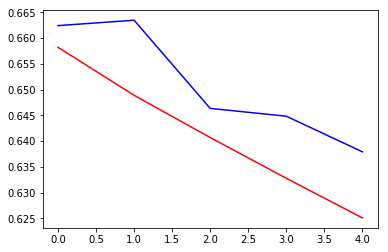

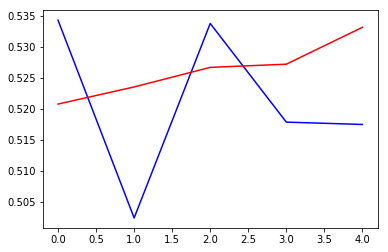

In [21]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

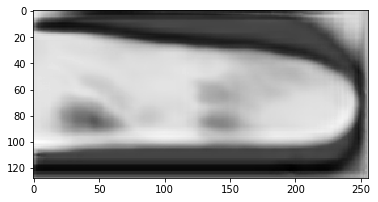

In [22]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

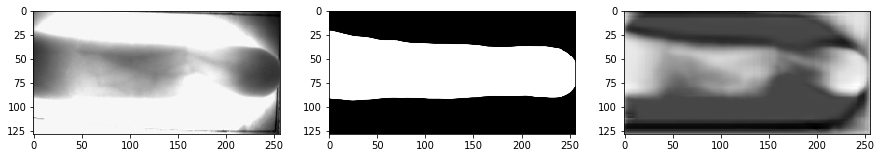

In [23]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0], cmap='gray')
ax[2].imshow(y_hat[0,:,:,0], cmap='gray')

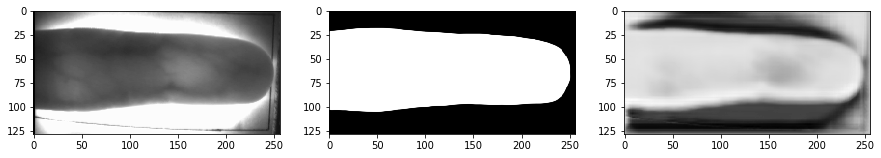

In [24]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(x_val[5,:,:,0], cmap='gray')
ax[1].imshow(y_val[5,:,:,0], cmap='gray')
ax[2].imshow(y_hat[5,:,:,0], cmap='gray')

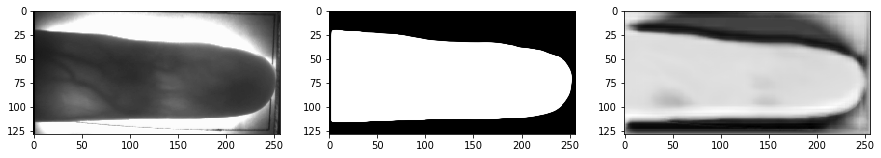

In [25]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(x_val[2,:,:,0], cmap='gray')
ax[1].imshow(y_val[2,:,:,0], cmap='gray')
ax[2].imshow(y_hat[2,:,:,0], cmap='gray')

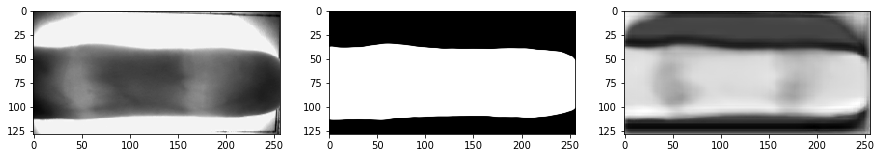

In [26]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(x_val[3,:,:,0], cmap='gray')
ax[1].imshow(y_val[3,:,:,0], cmap='gray')
ax[2].imshow(y_hat[3,:,:,0], cmap='gray')

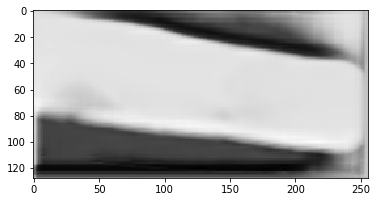

In [27]:
plt.imshow(model.predict(x_train[5].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

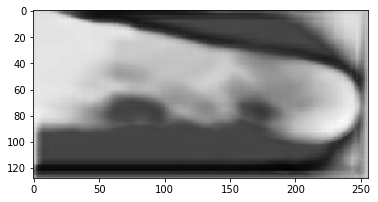

In [28]:
plt.imshow(model.predict(x_train[11].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

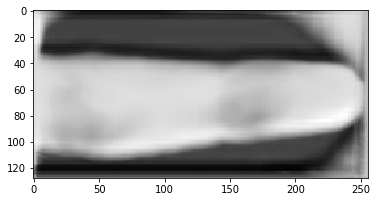

In [29]:
plt.imshow(model.predict(x_train[16].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

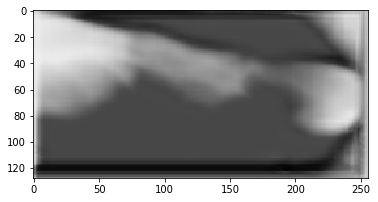

In [30]:
plt.imshow(model.predict(x_train[21].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')